# Implementation of Zurich transport network in Neo4j 


We opted for a `.graphml` format which was supported by _Neo4j_ as well as igraph to export and import the graph data


# Analysis of the Zuerich transport network

**Targeted deletion:**

To mimick a hostile attack, we will look at targeted deletion, e.g. when critical (in our case more important) nodes of the network are deleted. 
Node deletion is used to test the robustness and tolerance (of attacks) in networks. It is expected that the absence of any node in general increases the distance between the other nodes in the network, as paths are removed which previously contributed to the interconnection of the system.

Similar to Albert et al. (2000) we will eliminate a node based on its criticality to the network and - after that - evaluate the effect of the limination on shortest paths and our measures. Like Holme et al. (2002), we will recalculate the centrality (e.g. betweenness) of the nodes after prior removal of other nodes. 

To address the tolerance of the network and the effects of node removal we study the changes in shortest path, modularity and betweenness when a node at a time is removed in function of its centrality in the network (targeted removal). 

Criticality of nodes depends on the point of view - we are interested in the most crucial lines for a majority of passengers and hence flow. In the remainder we will focus on the betweenness centrality. Degree and betweenness are found to be frequent measures (Scott et al. 2006, von Ferber et al., 2009). The betweenness centrality based attacks have been found to be more efficient than attacks based on selection of nodes based on degree centrality (Nie et al. 2015). 
Consequently, in the remainder we will be focusing on basing our attack on network on these nodes that are most critical as defined by their betweenness centrality calculation. 

The analysis is carried out by iteratively removing the node with the highest **betweenness centrality**. At each iteration the following metrics are computed: communities with Leiden algorithm, shortest paths between pairs of selected nodes, modularity and betweenness measures.

However, it also makes sense to look at **EigenCentrality**, since this measure of centrality takes the nodes importance across the whole network into account. 
We will conduct our analysis as follows: 

### Shortest Paths and Modularity
**The shortest paths** are computed between pairs of randomly selected nodes.
The shortest paths are computed as follows: initially, more frequented subpaths would receive a s**maller (?) weight**, given that they are of higher importance. We assume right now that: to get the shortest paths, the method tries to minimize weights, so we chose to invert the frequency based weights.
As a result, the calculation of shortest paths is influenced by the weights given.

**Modularity** measures the strength of division of a network into clusters or communities. Hence, networks with high modularity are expected to have dense connections between the nodes within clusters but sparse connections between nodes in different clusters. Modularity helps to detect community structure in networks.

**Modularity calculation with the Leiden algorithm:**

We implemented the Leiden algorithmus for community detection. The Leiden algorithmus attempts to solve the shortcomings of the Louvain algorithm, and  yields communities that are guaranteed to be connected. Finally, the Leiden algorithm’s property is considered the newer and faster algorithm, it works only on neighborhoods that have recently been changed and speeds up computation by doing so. The Leiden algorithm allows for greater depth in choosing communities. When the Leiden algorithm is applied iteratively, it converges to a partition in which all subsets of all communities are locally connected. 


In [2]:
!pip install neo4j
!pip install python-igraph
!pip install easygui
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 3.5 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.3-py3-none-any.whl size=116069 sha256=171c968e3653abc668a44bd9807e302e140de5110d5de8715daafd53399c3f6a
  Stored in directory: /root/.cache/pip/wheels/db/dd/76/acacd519878f133f2f869aec70db548d89e04013209c3c62bc
Successfully built neo4j
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 556 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.2 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=4e023bb

In [3]:
from neo4j import GraphDatabase
import igraph as ig
from skimage.io import imread
import glob
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import warnings
import random
import numpy as np
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Implemented Functions

#### Graph saving and Visualization

In [34]:
def generate_graph(graph, modules, iteration=None, delete_previous_plots=True, layout='auto'):
  if not os.path.exists('clusters/'):
    os.mkdir('clusters/')
    
  if delete_previous_plots and iteration==1:
    for c in glob.glob('clusters/cluster*png'):
      os.remove(c)

  layout_gr = graph.layout(layout)

  colors =np.random.permutation(sns.color_palette("hls", len(modules))).tolist()
  #colors = sns.color_palette("hls", k)
  graph.vs['color'] = [None]
  for clid, cluster in enumerate(modules):
      for member in cluster:
          graph.vs[member]['color'] = colors[clid]

  visual_style = {}
  visual_style["vertex_size"] = 5
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  if iteration:
    pl.save('clusters/clusters_{}_iter{}.png'.format(len(modules), iteration))
  else:
    pl.save('clusters/clusters_{}.png'.format(len(modules)))
  #return pl

def plot_graphs(img_path='clusters/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'cluster*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][4:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//4 + 1
    cols = len(img_list)//2
  else:
    rows = len(img_list)//4
    cols = len(img_list)//2

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'iteration ' + imf.split('_')[-1][4:-4] + '\n' +'n_clusters: ' + imf.split('_')[1] 
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

In [37]:
def shortest_path_graph(graph, gspaths, iteration, delete_previous_plots=True):
  """
  graph: current subgraph or main graph 
  gspaths: all the graph shortest paths being monitored at the current iteration
  """
  if not os.path.exists('shortest_paths/'):
    os.mkdir('shortest_paths/')

  if delete_previous_plots and iteration==1:
    for c in glob.glob('shortest_paths/spaths*png'):
      os.remove(c)

  # set default layout properties
  layout_gr = graph.layout('drl')
  colors =sns.color_palette("hls", len(gspaths))
  graph.vs['color'] = ['black']
  graph.vs['size'] = 2

  i = 0

  # iterate over all the node pairs for which the shortest path are computed at each iteration 
  for spaths in gspaths:
        # pick paths related to one pair of node in the list
        paths = gspaths[spaths]
        # each pair might contain more than one shortest path (not sure why...but it returns a list)
        for path in paths:
          # assign properties to highlight all the paths associated to the analysed pair of nodes. 
          for n in path:
            graph.vs[n]['color'] = colors[i]
            graph.vs[n]['size'] = 10
        i+=1
  visual_style = {}
  visual_style["vertex_size"] = graph.vs['size']
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (400, 400)
  pl = ig.plot(graph, **visual_style)
  pl.save('shortest_paths/spaths_iteration_{}.png'.format(iteration))

def plot_shortest_paths(img_path='shortest_paths/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'spaths*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//4 + 1
    cols = len(img_list)//2
  else:
    rows = len(img_list)//4
    cols = len(img_list)//2

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'shortest paths' + '\n' + 'iteration ' + imf.split('_')[-1][:-4]
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

#### Graph Analysis

In [9]:
def get_most_central_node(subgraph, ref_ids=[], method='bwt'):
  # ref ids are the list of nodes that we do not want to remove from our graphs because they 
  # represent the nodes between which we want to compute the shortest paths
  if method=='btw':
    # Approach of most central node selection taken from excercise session 3
    betw = subgraph.betweenness(weights=subgraph.es["weight"])
    # Select node with the highest degree and betweenness
    vind = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index
    vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]]['id']
    while vind in ref_ids:
      betw.remove(np.amax(betw))
      vind = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index
      vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]]['id']
      
  elif method=='eig_cent':
    cent = subgraph.eigenvector_centrality()
    vind = subgraph.vs[np.argmax(cent)].index
    vid = subgraph.vs[np.argmax(cent)]['id']
    while vind in ref_ids:
      cent.remove(np.amax(cent))
      vind = subgraph.vs[np.argmax(cent)].index
      vid = subgraph.vs[np.argmax(cent)]['id']
  return vind, vid

In [64]:
def invert_weights(graph):
  for e in graph.es:
    e["weight"] = round(1/e["weight"], 2)
  return graph

In [10]:
def compute_spath_weight(graph, target_spaths):
  # this function takes the graph and the pre-computed shortest paths for a given list of reference points and returns a 
  # dictionary containing for each of them the total weight of their shortest path
  spath_weights = {}
  for targetpath in target_spaths:
    spaths=target_spaths[targetpath]
    pathweight=0
    for l in range(len(spaths[0])-1):
      eid = graph.get_eid(spaths[0][l], spaths[0][l+1], directed=False)
      pathweight += graph.es[eid]["weight"]
    spath_weights[targetpath] = pathweight
  return spath_weights

In [11]:
def get_spaths_node_ids(graph, target_spaths):
  # this function takes the graph and the pre-computed shortest paths for a given list of reference points and 
  # and convert the nodes indexes in the shortest path to node ids
  spath_ids = {}
  for targetpath in target_spaths:
    spaths=target_spaths[targetpath]
    spath_ids[targetpath] = [graph.vs[n]['id'] for n in spaths[0]]
  return spath_ids

In [12]:
def retrieve_internal_ids(graph, ref_substop_ids):
  # converts node ids to graph indexes
  ref_node_ids = []
  for v in graph.vs:
    if int(v['id']) in ref_substop_ids:
      ref_node_ids.append(v.index)
  return ref_node_ids

In [13]:
def compute_shortest_path(graph, pairs):
  shortest_paths = {}
  for p in pairs:
    pair_indexes = retrieve_internal_ids(graph, list(p))
    shortest_paths[str(p)] = graph.get_shortest_paths(pair_indexes[0], to=pair_indexes[1], weights=graph.es["weight"], output="vpath",)
  return shortest_paths

In [14]:
def process(graph_undirected, pairs, ref_substop_ids, iterations=10, save_plots=True):
  patience = 0
  i = 0
  metrics = pd.DataFrame(columns=['subgraph', 'modules', 'iteration', 'betweenness', 'shortest_path', 'modularity'])
  while (patience <= 3) & (i <= iterations):
    #for i in range(iterations):
    if i==0:
      # in the first iteration we don't remove anything, we just compute the baseline measures
      subgraph = graph_undirected.copy() 
      msg = 'number of nodes: {}, number of edges: {}'.format(subgraph.vcount(), subgraph.ecount())
      v_id = None
    else:
      # get most central vertex
      ref_ids = retrieve_internal_ids(subgraph, ref_substop_ids) 
      v_ind, v_id = get_most_central_node(subgraph, ref_ids, method='btw') 
      # remove from subgraph
      subgraph.delete_vertices(v_ind)
      msg = 'ITER{} removed node {}, number of nodes: {}, number of edges: {}'.format(i, v_id, subgraph.vcount(), subgraph.ecount())
    leid = subgraph.community_leiden(weights=subgraph.es["weight"], resolution_parameter=.5) # the lower resolution_parameter the lesser communities (i.e. bigger clusters)
    sp = compute_shortest_path(subgraph, pairs)
    sw = compute_spath_weight(subgraph, sp)
    spids = get_spaths_node_ids(subgraph, sp)
    row = pd.Series(data = {'subgraph': subgraph.copy(), 
                            'iteration': i, 
                            'modules': leid,
                            'betweenness': subgraph.betweenness(weights=subgraph.es["weight"]), #
                            'shortest_paths': sp,
                            'shortest_path_weights':sw,
                            'modularity': leid.modularity,
                            'n_clusters': len(leid),
                            'removed_node_id':v_id,
                            'n_edges':subgraph.ecount(),
                            'n_nodes':subgraph.vcount(),
                            'shortest_path_ids': spids})
    metrics = metrics.append(row, ignore_index=True)
    if save_plots:
      generate_graph(subgraph, leid, iteration=i+1, layout='drl')
    print(msg)

    if max(sp.values())==0:
      patience += 1
    else:
      patience = 0
    i+=1

  return metrics

In [28]:
def generate_random_pairs(n_pairs, graph, source_list=[]):
  # random pairs of nodes to be considered as ends of the shortest paths to monitor. can be selected randomly from the graph or from a given list of node ids
  j = 0
  pairs = []
  while j < n_pairs:
    if not source_list:
      ids_list = random.sample(graph.vs['id'], 2)
      p = (int(ids_list[0]), int(ids_list[1])) 
    else:
      ids_list = random.sample(source_list, 2) # repeat 
      p = (ids_list[0], ids_list[1]) 
    if (p not in pairs) and ((p[1], p[0]) not in pairs):
        pairs.append(p)
        j+=1
  return pairs, ids_list

#### Result plots

In [49]:
def collect_weights_across_iterations(target_path, metrics):
  # retrieve shortest path weights across the iterations for each monitored pair of nodes
  iteration_weights = []
  for r in metrics.to_dict(orient="records"):
    iteration_weights.append(r['shortest_path_weights'][str(target_path)])
  return iteration_weights

def get_substop_name(target_path, substop_df_path):
  # convert pairs of node ids into the Location names associated with them
  substops = pd.read_excel(substop_df_path)
  start, dest = substops[substops['ID SUBSTOP'] == target_path[0]]['LOCATION'].values[0], substops[substops['ID SUBSTOP'] == target_path[1]]['LOCATION'].values[0]
  return (start, dest)

def plot_results(metrics_df, pairs, substop_path=None, random_ref_nodes=False):
  # random_ref_nodes indicates whether the plots are related to pairs of reference nodes selected at random from the graph or
  # picked from the provided substops
  sns.set_style('dark')
  plt.subplot(221)
  s = sns.lineplot(x='iteration', y='n_clusters', data=metrics_df)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("n_clusters",fontsize=15)
  plt.title(" Number of clusters detected across iterations ", fontsize=20);
  plt.subplot(222)
  s = sns.lineplot(x='iteration', y='n_edges', data=metrics_df)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("n_edges",fontsize=15)
  plt.title(" Number of edges in the graph across iterations ", fontsize=20);
  plt.subplot(223)
  labs = []
  for p in pairs:
    iteration_weights = collect_weights_across_iterations(p, metrics_df)
    if random_ref_nodes:
      s = sns.lineplot(x='iteration', y=iteration_weights, data=metrics_df)
    else:
      start, dest = get_substop_name(p, substop_path)
      s = sns.lineplot(x='iteration', y=iteration_weights, data=metrics_df, label=str((start, dest)))
      plt.legend()
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("shortest path weight",fontsize=15)
  plt.title(" Change of shortest path total"+"\n"+"weights across iterations ", fontsize=20);
  plt.subplot(224)
  s = sns.lineplot(x='iteration', y='modularity', data=metrics_df)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("Modularity",fontsize=15)
  plt.title(" Modularity changes across iterations ", fontsize=20);

## Visual analysis: 

A first visualization of the graph of Zurich's transport network is displayed below. From the graph created we can see the following: 
- There are no node unconnected, thus all substops on a line are in a "loop" - which is logical since the underlying data is transport lines. 
- The distance of some nodes is higher than between others, substops are in row like pearls. 
- The majority of nodes has one in and one out edge (degree). 
- We can see that there are three major nodes that bundle the majority of connections and one third node further apart. They could be interpreted as node points of the transport system, such as the main train station, the airport or a central square within Zurich. 
- The design of the Zurich public transportation network is nicely visible: Most of the lines run in a "circle", we have almost no final stops that are not connected to another substop. This is not necessarily guaranteed during network design, such as seen in Háznagy et al. (2015). 

In [18]:
z = ig.Graph.Read_GraphML("/content/drive/My Drive/ALSSN/zurich.graphml")

Extraction of attributes for the edges and the nodes
The attributes for the edges are: weight, label and id, the attributes for the vertices are: location, id, labels.

The graph consists of vertices 1346, each one representing a different substop.


In [19]:
z.edge_attributes(), z.vertex_attributes()

(['weight', 'label', 'id'], ['location', 'id', 'labels'])

In [20]:
z.vcount(), z.is_directed(), z.is_weighted()

(1346, True, True)

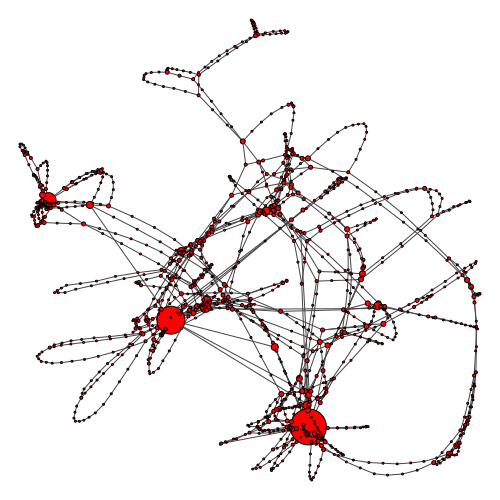

In [21]:
graph = z.copy()
graph.to_undirected(combine_edges=dict(weight="sum"))
layout_gr = graph.layout("auto")
visual_style = {}
visual_style["vertex_size"] = z.degree()
# visual_style["vertex_label"]=z.vs['labels'] #   z.degree >= 3]
# visual_style["vertex_color"] = z.vs['id']
visual_style["layout"] = layout_gr
visual_style["edge_width"] = 1
#visual_style["edge_label"]= z.es['label']
visual_style["bbox"] = (500, 500)
ig.plot(graph,  **visual_style )


### Centrality measures
For an initial overview on the centrality of nodes in the transport network, we opted for betweenness and degree as widely used measures for centrality. In general there are different approaches to calculate/measure centrality with application in transport networks, such as: criticality of nodes (Núñez and Palomares, 2014),  a combination of degree and betweenness centrality (Nie et al. 2015). Yet degree and betweenness are found to be frequent measures (Scott et al. 2006, von Ferber et al., 2009). 

**Degree centrality:** Defines the number of links associated with a node. The more links a node has, the higher its degree and hence its “central” position in the network (e.g. its importance). 

**Betweeness centrality:** The shortest path betweenness of a vertex  is defined to be the fraction of shortest paths between pairs of vertices in a network that pass through the vertex. / Betweenness counts the times that a node is passed being a “bridge” between pairs of two other nodes. As a result, a node with higher betweenness centrality represents a more important/influencing point within the network, because more transport lines and thus more connections and passengers will pass through that node. The higher a node’s betweenness, the more important they are for the efficient flow of people/connections in a transport network. 

**Eigen Centrality:**A node's influence is determined based on the amount of links it has to other nodes in the network. Eigencentrality also takes into account how well the node  is connected and how many links a node has. The advantage of eigen centrality is that nodes with influence over the whole network are identified. 

Other measures such as **closeness centrality** are not of importance to us, since we are not looking to identify the best placed transport stations in a network but focusing on the flow/throughput of the latter. Also closeness in highly connected networks have a similar score in many times, which is not useful in our case. 


### Plots of degree, betweenness and eigenvector centrality

Below the plots of degree, betweenness and eigenvector centrality are displayed. 

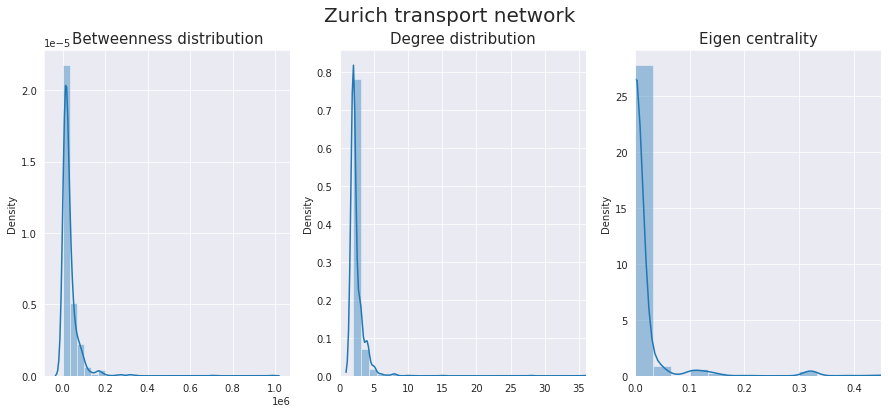

In [22]:
btw = z.betweenness()
deg = z.degree()
eigen = z.eigenvector_centrality()
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
plt.suptitle('Zurich transport network', fontsize=20)
plt.subplot(131)
sns.distplot(btw, bins=30)
plt.ticklabel_format(axis='x', style='sci', scilimits=[0, .6])
plt.title('Betweenness distribution', fontsize=15)
plt.subplot(132)
sns.distplot(deg, bins=30)
plt.xlim([0,36])
plt.title('Degree distribution', fontsize=15);
plt.subplot(133)
sns.distplot(eigen, bins=30)
plt.xlim([0,0.45])
plt.title('Eigen centrality', fontsize=15);

**Interpretation:**

**Betweenness Plot:** Majority of betweenness values between 0.0 and 0.1. We are interested in nodes that display a betweenness close to 0.2. As mentioned earlier, a node with higher betweenness centrality represents a more important/influencing point within the network, because more transport lines and thus more connections and passengers will pass through that node.

**Degree Plot:**Majority of degrees between 0 to 5. We are interested in the few nodes that exhibit a higher degree than 3 (?). As mentioned earlier, the more links a node has, the higher its degree and hence its “central” position in the network (e.g. its importance).

**EigenCentrality Plot:** Majority of eigencentrality values are close to 0. We can distinguish some "outliers" with higher eigencentrality values at 0.1 and 0.3. Especially the eigencentrality values of 0.3 are of interest, since these represent more influential nodes across the whole network. 

Taking a closer look at the degree distribution shown below, we observe here a somewhat homogeneous network, in which each node has approximately the same number of links, 2-3. This is important for the latter part of analysis.  Yet we also find that few links have a very high degree, such as 36, 28, 15 and 10. We have seen them earlier in the overall graph plot.
This indicates that we do have few linkage "extrema" with a few nodes exhibiting a lot of in- and out links versus others containing only few.

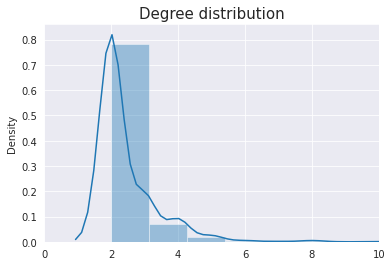

In [23]:
sns.distplot(deg, bins=30)
plt.xlim([0,10])
plt.title('Degree distribution', fontsize=15);

In [ ]:
deg_sorted = deg.copy()
deg_sorted.sort(reverse=True)
print(deg_sorted)

mean_degree = np.mean(deg)
print(mean_degree)

[36, 28, 15, 10, 8, 8, 8, 8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

## Experiments

In this section we want to assess how hard it is to make the Zurich's transport system to fail by monitoring how quickly we get to a point at which is not possible anymore to find a path between the selected node pairs.

To continuously assess communities in the process of node deletion and apply either the Leiden or the Louvain algorithm, the graph needs to be undirected.

In [65]:
# convert network to undirected in order to perform the Louvain/Leiden algorithm
z_undirected = z.copy()
z_undirected.to_undirected(combine_edges=dict(weight="sum"))
#z_undirected = invert_weights(z_undirected)

### Experiment 1: random generation of reference node pairs taken from the Touristic Substop node information

In this first experiment, we create random combinations of the touristic substops in Zurich. Such pairs will be used as start and end nodes for which we will monitor the shortest path changes at each iteration. 

In [57]:
# parameter setup 
n_iter = 50
n_pairs = 8
substop_path = '/content/drive/My Drive/ALSSN/touristic_substops.xlsx'

In the following step, the process of node removal is started. In each iteration, all the metrics along with the number of remaining nodes edges in the graph are recalculated. 

In [66]:
touristic_substops = pd.read_excel(substop_path)
pairs_ex1, ref_node_ids_ex1 = generate_random_pairs(n_pairs, z_undirected, touristic_substops['ID SUBSTOP'].to_list())
metrics_ex1 = process(z_undirected, pairs_ex1, ref_node_ids_ex1, iterations=n_iter, save_plots=True)

InternalError: ignored

#### Graph topology changes across iterations



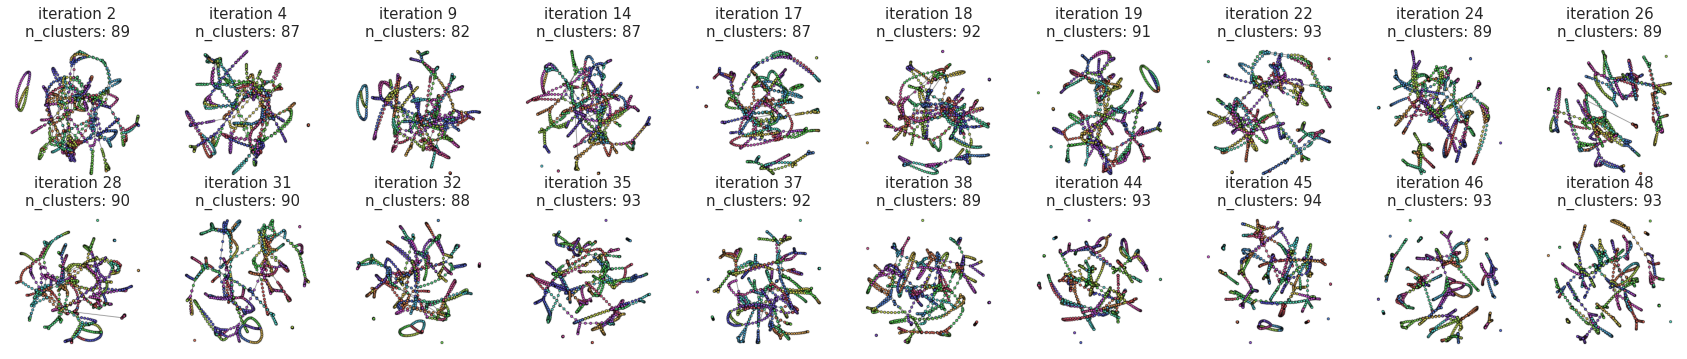

In [30]:
plt.figure(figsize=(30, 15))
plot_graphs(sample=True)

#### Shortest path changes between reference node pairs across iterations

In [31]:
ref_graph = metrics_ex1.loc[0, 'subgraph']
for r in metrics_ex1.to_dict(orient="records"):
  shortest_path_graph(ref_graph, r['shortest_paths'], r['iteration'])

The colored points represent the itinerary of the previously calculated shortest paths across the network. Each color is associated with a different pair of reference nodes being monitored


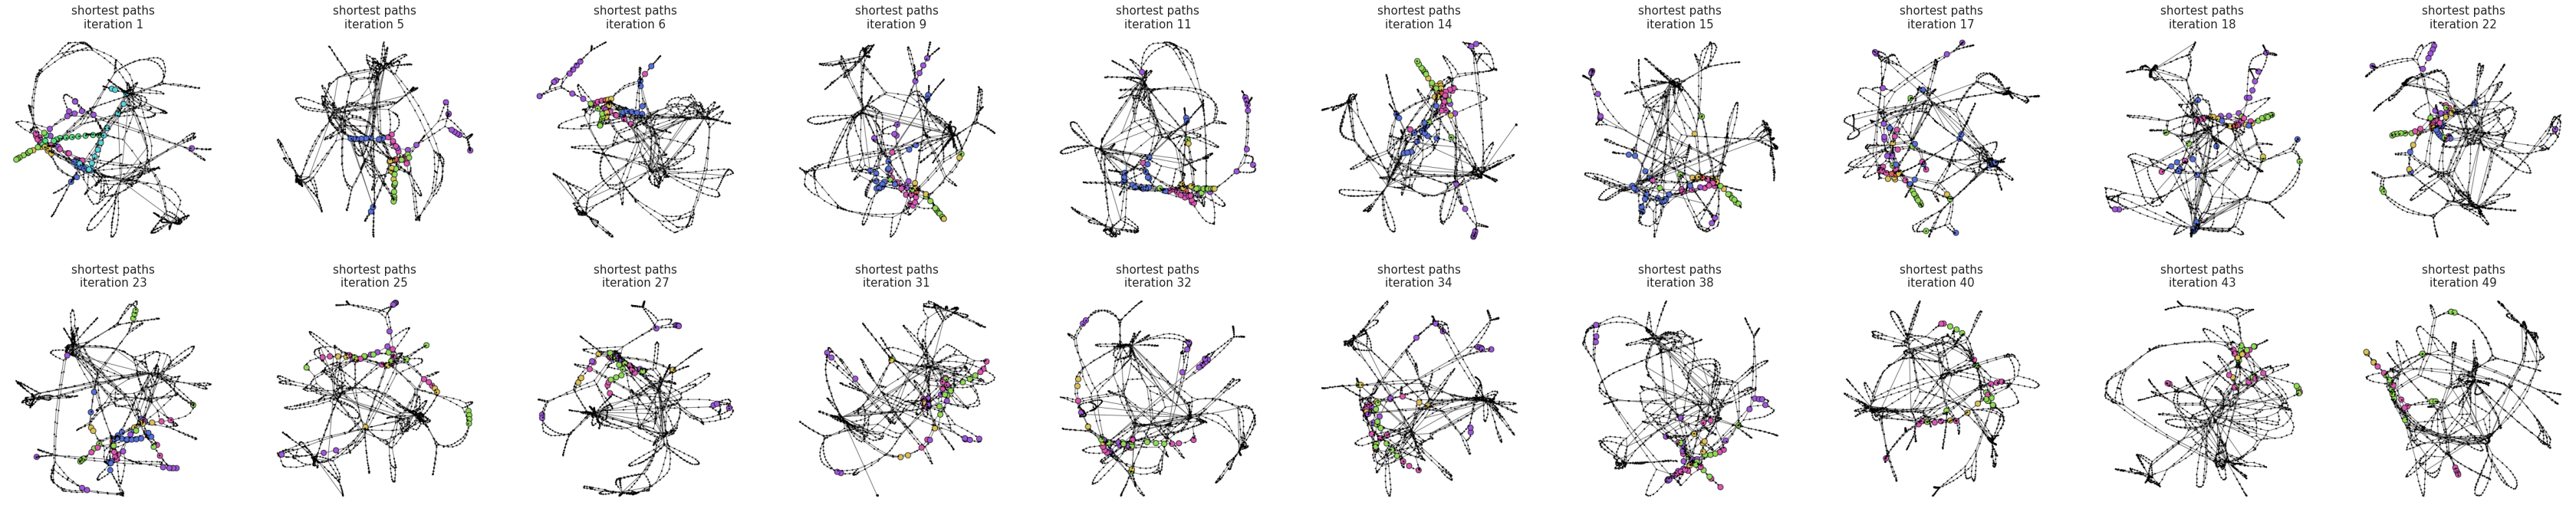

In [42]:
plt.figure(figsize=(60, 30))
plot_shortest_paths()

### Experiment 2: random generation of reference node pairs extracted from the graph
In this second experiment, we create random combinations of nodes directly picked from the whole network. As in experiment 1, such pairs will be used as start and end nodes for which we will monitor the shortest path changes at each iteration. 

In [43]:
# parameter setup 
n_iter = 50
n_pairs = 8

In [44]:
pairs_ex2, ref_node_ids_ex2 = generate_random_pairs(n_pairs, z_undirected)
metrics_ex2 = process(z_undirected, pairs_ex2, ref_node_ids_ex2, iterations=n_iter, save_plots=True)

number of nodes: 1346, number of edges: 1657
ITER1 removed node 46016, number of nodes: 1345, number of edges: 1636
ITER2 removed node 46024, number of nodes: 1344, number of edges: 1609
ITER3 removed node 47747, number of nodes: 1343, number of edges: 1606
ITER4 removed node 44487, number of nodes: 1342, number of edges: 1600
ITER5 removed node 45736, number of nodes: 1341, number of edges: 1587
ITER6 removed node 43732, number of nodes: 1340, number of edges: 1583
ITER7 removed node 46697, number of nodes: 1339, number of edges: 1579
ITER8 removed node 45902, number of nodes: 1338, number of edges: 1570
ITER9 removed node 45994, number of nodes: 1337, number of edges: 1566
ITER10 removed node 43774, number of nodes: 1336, number of edges: 1561
ITER11 removed node 44450, number of nodes: 1335, number of edges: 1554
ITER12 removed node 45703, number of nodes: 1334, number of edges: 1548
ITER13 removed node 45362, number of nodes: 1333, number of edges: 1544
ITER14 removed node 46883, n

#### Graph topology changes across iterations

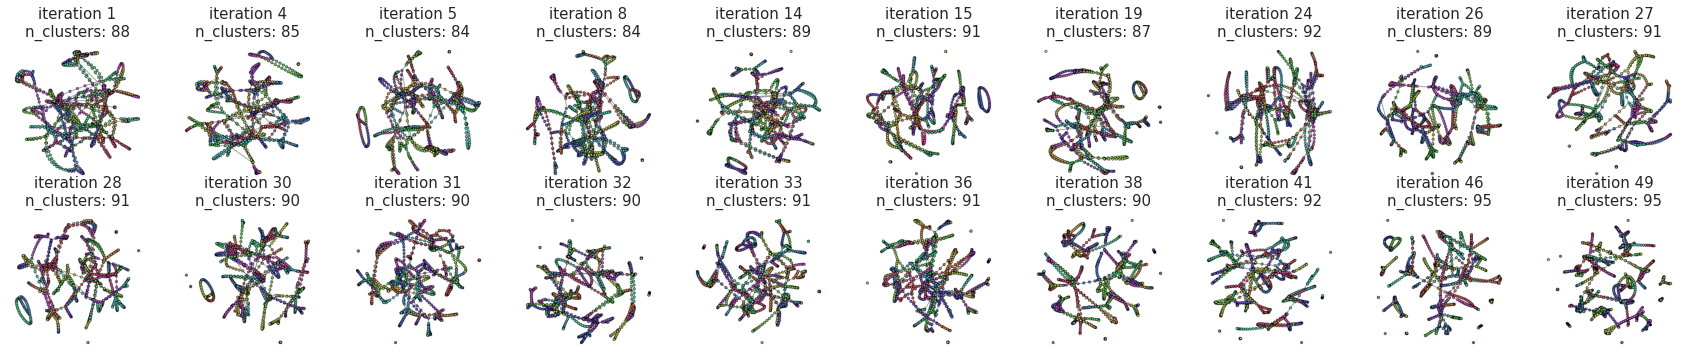

In [45]:
plt.figure(figsize=(30, 15))
plot_graphs(sample=True)

Visual analysis of the graphs:

As we can see in the visualization, the elimination of connected nodes greatly changes a graph's topology. With every iteration of the node removal process, we can observe that the clusters are becoming more and more fragmented.

Application of the Leiden Algorithm: Clusters become more and more separated across iterations as expected. Yet, we cannot observe a sudden surge in the number of clusters in the initial steps of node deletion. During the process, we observe that nodes and subclusters seemingly get reassigned to other clusters: The number of clusters for example first increases in iteration 4 to 35, reaching a number of clusters at around 80-90. After that, the number of clusters decreases slightly, indicating that a node must have been deleted within a subcluster, causing the latter to be "reassigned" to another cluster.

*- we should check whether we get to a condition in which we have pretty well separated clusters consisting of multiple nodes (i.e. not only one node clusters) - why? *

After iteration 50, 50 nodes have been removed from the graph. This corresponds to 4% of the graph only. Yet with the removal of 4% of the nodes we can clearly see the fragmentation effect.

Fragmentation behaviour under node removal is also depending on the number of links that each node is in average connected to: The more connections, the slower the fragmentation process (Nguyen and Trang Le, 2019).

The average number of links in the underlying network is 2.49. Hence we expect a rather fast fragementation process.

#### Shortest path changes between reference node pairs across iterations

In [46]:
ref_graph = metrics_ex2.loc[0, 'subgraph']
for r in metrics_ex2.to_dict(orient="records"):
  shortest_path_graph(ref_graph, r['shortest_paths'], r['iteration'])

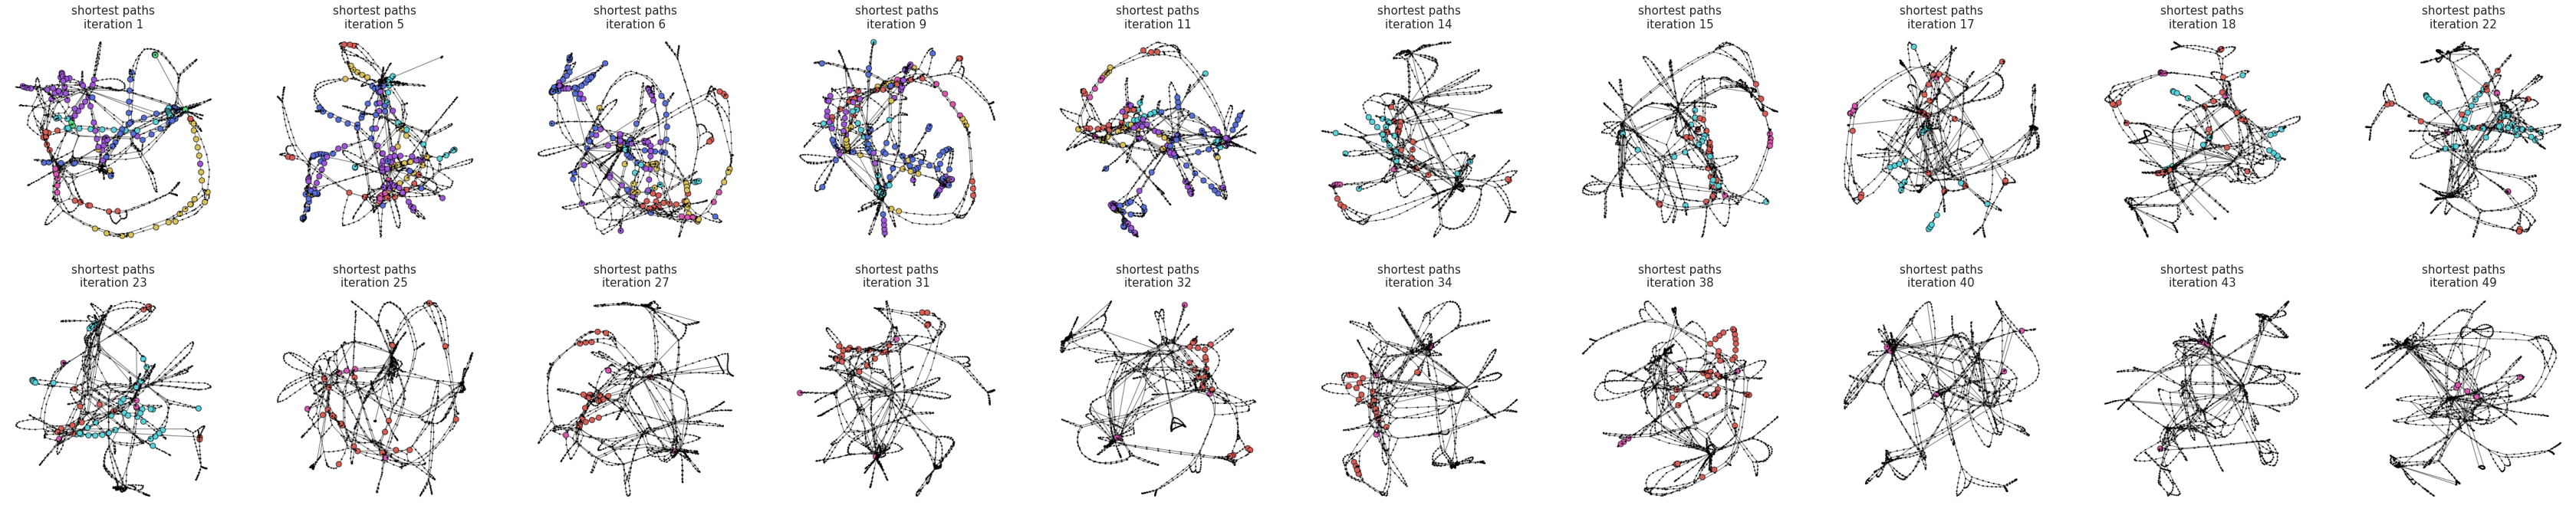

In [47]:
plt.figure(figsize=(60, 30))
plot_shortest_paths()

## Result Discussion

### Results from experiment 1

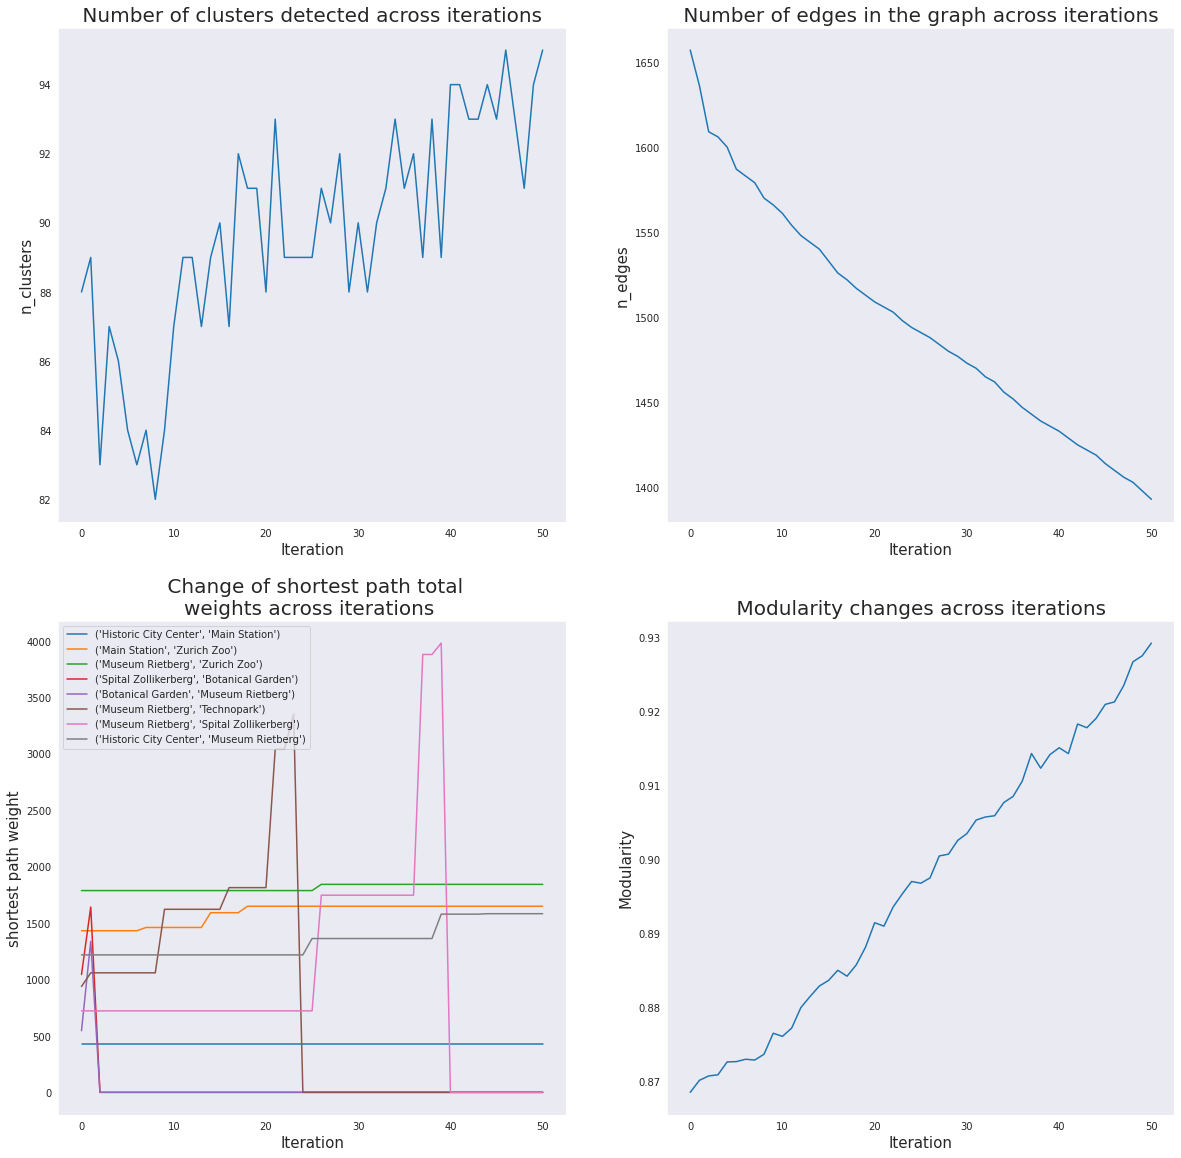

In [53]:
plt.figure(figsize=(20, 20))
plot_results(metrics_ex1, pairs_ex1, substop_path, random_ref_nodes=False)

### Results from experiment 2

No handles with labels found to put in legend.


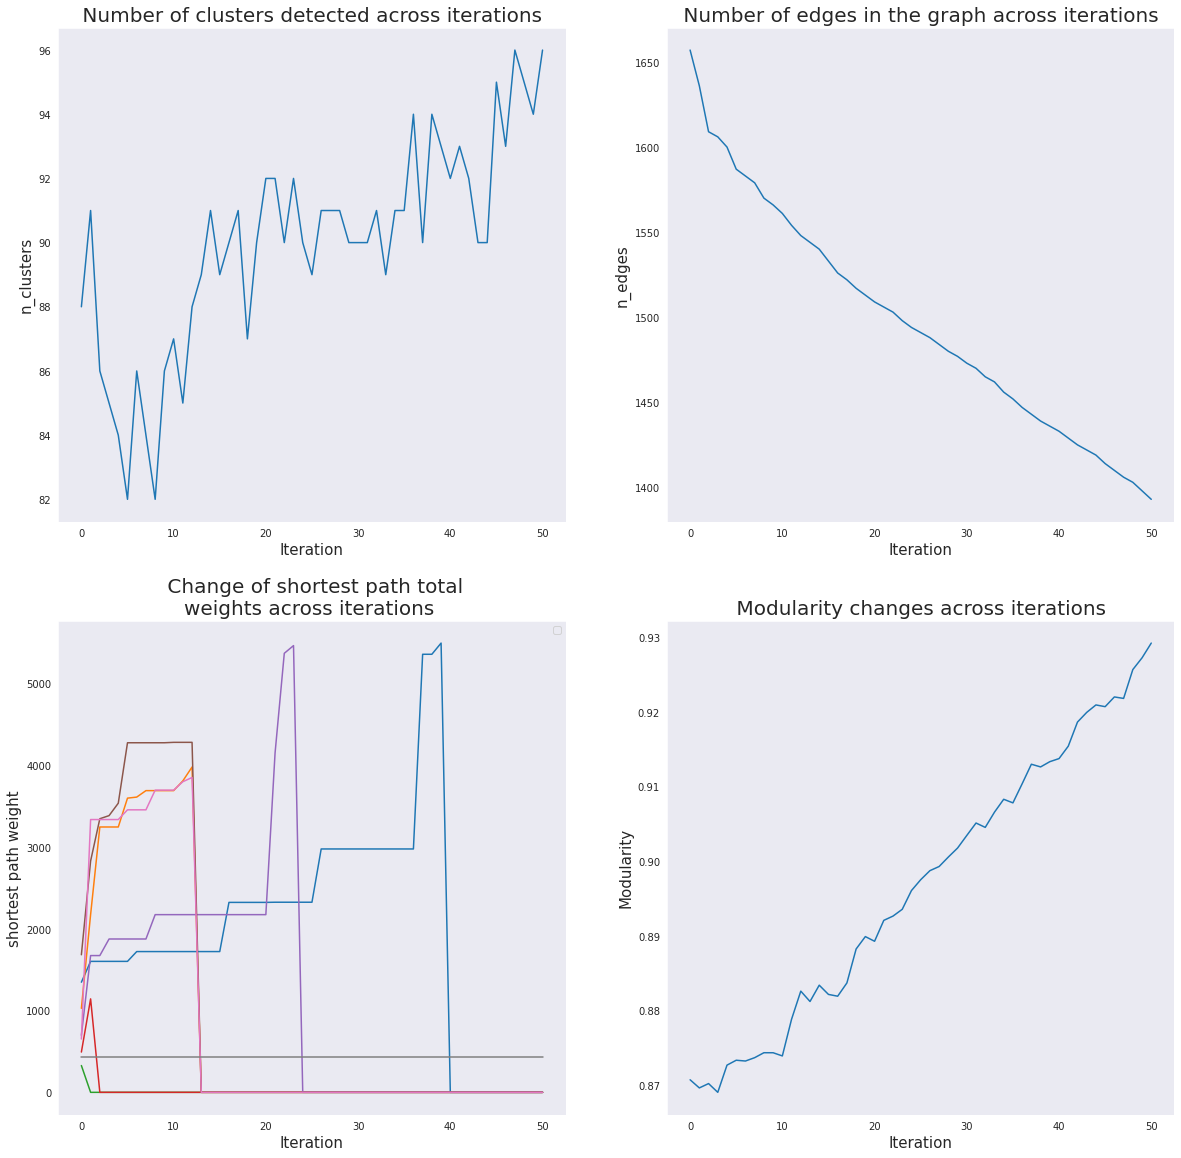

In [54]:
plt.figure(figsize=(20, 20))
plot_results(metrics_ex2, pairs_ex2, random_ref_nodes=True)

**Analysis:** Comparison of community detection algorithms when measured iteratively during targeted deletion. We have experimented both with the Louvain as well as with the Leiden algorithm and observe differences in the fragmentation process:  

**Leiden:** When the Leiden algorithm is applied, we distinguish the number of clusters increaseing, yet this does not appen in a monotonic fashion but wit suddenspikes and surges in the number of clusters as more and more nodes get deleted form the network.

**Louvain:** In comparison to this, the louvain algorithm displayed a steady monotonic increase during further progress of node deletion. Yet we assume that one of the louvains algorithms shortcomings, arbitrarily badly connected communities, also takes place here

We assume that the networks "behaviour" in clustering/fragmentation is one of the effects of the improvements of the Leiden algorithm:  the algorithm attempts at keeping all nodes to subsets of communities optimally assigned. 

- how is the number of clusters in the end when comparing both? 

- Since we do not have and node with a higher degree of connection than XX, we should not have any node with a higher degree than 3, e.g. the removed edge would have to cause a whole line to fall then. **(?)**

**In the recalculation of the remaining edges per node we can also see the following:**

A sudden drop in the number of edges during node removal points towards the fact that the deleted node must have been of high degree. 

It is expected that this removal drastically alters the network's topology (Albert et al. 2002), which we will observe as our analysis progresses. 

**Number of Cluster plot:**
When the Leiden algorithm is applied, we an detect sudden "surges" in the number of clusters. This happens when a connecting node within a cluster is removed, causing the cluster to split. We also observe the Leiden algorithms capacity to "reassign" these nodes and fragmented subclusters to another cluster, which reduces the overall number of clusters detected.

**Modularity plot:**
Yet the initial (and foregoing) modularity score greatly depends on the sequence and degree of removed nodes. Thus the number of clusters detected during the removal process varies across runs.

We can observe that the level of modularity during the node removal process does not increase nor decrease much. Again, modularity measures the strength of division of a network into clusters or communities. Hence, networks with high modularity are expected to have dense connections between the nodes within clusters but sparse connections between nodes in different clusters. Modularity helps to detect community structure in networks.

An initial modularity score of 0.87 is achieved, that only increases to 0.88 across iterations. this is a somewhat "acceptable" score for modularity, when comparing to the results of the Leiden algorithm development by Traag et al. (2019) with modularity values between 0.83 and 0.97.  

Yet, Nguyen and Trang Le (2019) found that networks with higher modularity Q have lower robustness to node removal. As a consequence, we expect that since the modularity values obtained are fairly high, they must plummet/greatly reduce with further iterations of node removal.  

This is in line with our expectations: 
When nodes are removed from a network, clusters of nodes whose links to the system disappear may be cut off (fragmented) from the main cluster.
With an increased removal of nodes we expect to have more fragmented nodes in the cluster that are not connected to the main clusters any more.
We expect clusters to fall apart, resulting in a sharp increase in the number of clusters and hence a decrease in the modularity score.  

Percolation phase: 

- can we see a moment of sudden collapsing during removal of more nodes?

**Shortest path overall weight plot:**

**With regard to the weights behaviour during node removal:**
The the weights of the shortest paths increase when the nodes are removed, indicating also the shortest path changes and necessarily gets longer. As a consequence, the overall weights on the shortest paths increase. 

# Analysis

What do we expect from the leiden algorithmus? 
the less nodes the smaller or the less communities
thus modularity XX, such as in (get results from other papers) 
How do the clusters behave over time?  Can we introduce a measure for the number of clusters? 

shortest path necessarily gets longer and then vanishes
- how can we translate that? 


print modularity and shortest path length somehow. 



# Sources


A. Háznagy, I. Fi, A. London and T. Nemeth, "Complex network analysis of public transportation networks: A comprehensive study," 2015 International Conference on Models and Technologies for Intelligent Transportation Systems (MT-ITS), 2015, pp. 371-378, doi: 10.1109/MTITS.2015.7223282.

Nuñez, E., & Palomares, J.J. (2014). Measuring the vulnerability of public transport networks.

Scott, D. M., Novak, D. C., Aultman-Hall, L. and Guo, F. (2006) Network robustness index: A new method for identifying critical links and evaluating the performance of transportation networks. Journal of Transport Geography 14, 215–227. 

von Ferber, C., Holovatch. T., Holovatch, Y. and Palchykov V. (2009) Public transport networks: empirical analysis and modeling. The European Physical Journal B 68, 261-275 

Albert, R., Jeong, H. & Barabási, AL. Error and attack tolerance of complex networks. Nature 406, 378–382 (2000). https://doi.org/10.1038/35019019

Holme P, Kim BJ, Yoon CN, Han SK. Attack vulnerability of complex networks. Phys Rev E Stat Nonlin Soft Matter Phys. 2002 May;65(5 Pt 2):056109. doi: 10.1103/PhysRevE.65.056109. Epub 2002 May 7. PMID: 12059649.

Nie, T., Guo, Z., Zhao, K., & Lu, Z. (2015). New attack strategies for complex networks. Physica A-statistical Mechanics and Its Applications, 424, 248-253.

Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

Nguyen Q, Pham HD, Cassi D, Bellingeri M (2019) Conditional attack strategy for real-world complex networks. Physica A 530:121561
